In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import glob, os
import tifffile as tif
from skimage import io, exposure

from microfilm.microplot import microshow
import microfilm as mf
import aicsimageio as aio

def normalize(img):
    img = exposure.rescale_intensity(img, out_range=(0, 1))
    return img

def apply_pseudocolor(gray, color):
    """
    Map a 2D grayscale image to RGB using a pseudo-color.
    
    gray: 2D array (normalized between 0–1)
    color: tuple of (R, G, B), values between 0–1
    """
    gray = np.clip(gray, 0, 1)  # ensure valid range
    rgb = np.zeros((gray.shape[0], gray.shape[1], 3))
    for i in range(3):
        rgb[..., i] = gray * color[i]
    return rgb

def apply_white_pseudocolor(gray):
    """
    Map a 2D grayscale image to white pseudo-color in RGB.
    Each pixel gets RGB = (gray, gray, gray).
    
    gray: 2D array normalized to [0, 1]
    returns: 3D RGB array
    """
    gray = np.clip(gray, 0, 1)
    return np.stack([gray] * 3, axis=-1)  # same value in R, G, B


In [3]:
hormonal_conditions = ['ESTR_AG', 'ESTR_INH', 'ANDR_AG', 'ANDR_ANT', 'ARYL_INH',
       'ARYL_AG', 'LX_AG', 'GC_AG', 'LX_INH', 'GC_INH', 'THYR_INH',
       'THYR_AG', 'DMSO', 'RET_AG',
       'RET_INH', 'ANDR_INH']
hormonal_conditions.remove('DMSO')
hormonal_conditions.sort()
hormonal_conditions = ['DMSO'] + hormonal_conditions

colors = { 3: sns.dark_palette('#0072b2', as_cmap=True), #(0, 114, 178)
            2 : sns.dark_palette('#009e73', as_cmap=True), #(0, 158, 115)
            1 : sns.dark_palette('#d55e00', as_cmap=True), #(255,255,255)
            0 : sns.dark_palette('#ffffff', as_cmap = True)
        }

#colors = { 3: mf.colorify.cmaps_def('pure_cyan'),
#            2 : mf.colorify.cmaps_def('pure_green'),
#            1 : mf.colorify.cmaps_def('pure_magenta'),
#            0 : mf.colorify.cmaps_def('pure_yellow')
#        }


In [4]:
img = aio.AICSImage("/group/testa/Project/EndPoints/TPSSU/Pictures/20240424_manuel_lessi_0141.czi")

In [5]:

pixel_size = img.physical_pixel_sizes.X
del img

In [6]:
pixel_size

0.325

In [7]:
good_images = ["20240424_manuel_lessi_0128_ScanRegion0_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0128_ScanRegion1_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0128_ScanRegion2_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0128_ScanRegion3_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0128_ScanRegion4_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0128_ScanRegion5_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion0_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion1_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion2_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion3_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion4_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0129_ScanRegion5_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0130_ScanRegion0_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0130_ScanRegion1_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0130_ScanRegion2_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0130_ScanRegion3_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0130_ScanRegion4_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion0_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion2_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion3_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion4_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion5_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0132_ScanRegion4_rep_0_channel_3_organoid_mask",
"20240424_manuel_lessi_0132_ScanRegion5_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0133_ScanRegion4_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0134_ScanRegion0_rep_1_channel_3_organoid_mask",
"20240424_manuel_lessi_0134_ScanRegion2_rep_2_channel_3_organoid_mask",
"20240424_manuel_lessi_0131_ScanRegion1_rep_0_channel_3_organoid_mask"]

good_images = [i.replace('_channel_3_organoid_mask', '') for i in good_images]
len(good_images) * 4

112

# Load sample sheet and file paths

In [8]:
sample_sheet = pd.read_csv('endpoints_ImageAnalysisSampleSheet.csv', sep = ';')
sample_sheet['sample_name'] = sample_sheet['Path'].apply(lambda x: x.split('\\')[-1]) + '_' + sample_sheet['Scan Area']
sample_sheet['unique_condition'] = sample_sheet['Condition'] + '_' + sample_sheet['Line ']

In [9]:
plot_dict = {}

for i in good_images:
    plot_dict['_'.join(i.split('_')[:-2])] = {}
    for j in range(4):
        plot_dict['_'.join(i.split('_')[:-2])][j] = f"/group/testa/Project/EndPoints/TPSSU/analysis/single_tif_organoids/{i}_channel_{j}_organoid_mask.tif"

In [10]:
len(plot_dict)

28

In [11]:
sample_sheet['sample_name']

0     20240424_manuel_lessi_0128_ScanRegion0
1     20240424_manuel_lessi_0128_ScanRegion1
2     20240424_manuel_lessi_0128_ScanRegion2
3     20240424_manuel_lessi_0128_ScanRegion3
4     20240424_manuel_lessi_0128_ScanRegion4
                       ...                  
83    20240424_manuel_lessi_0143_ScanRegion5
84    20240424_manuel_lessi_0144_ScanRegion0
85    20240424_manuel_lessi_0144_ScanRegion1
86    20240424_manuel_lessi_0144_ScanRegion2
87    20240424_manuel_lessi_0144_ScanRegion3
Name: sample_name, Length: 88, dtype: object

In [12]:
imageName_ScanRegion_good_images = list(plot_dict.keys())
imageName_ScanRegion_good_images

['20240424_manuel_lessi_0128_ScanRegion0',
 '20240424_manuel_lessi_0128_ScanRegion1',
 '20240424_manuel_lessi_0128_ScanRegion2',
 '20240424_manuel_lessi_0128_ScanRegion3',
 '20240424_manuel_lessi_0128_ScanRegion4',
 '20240424_manuel_lessi_0128_ScanRegion5',
 '20240424_manuel_lessi_0129_ScanRegion0',
 '20240424_manuel_lessi_0129_ScanRegion1',
 '20240424_manuel_lessi_0129_ScanRegion2',
 '20240424_manuel_lessi_0129_ScanRegion3',
 '20240424_manuel_lessi_0129_ScanRegion4',
 '20240424_manuel_lessi_0129_ScanRegion5',
 '20240424_manuel_lessi_0130_ScanRegion0',
 '20240424_manuel_lessi_0130_ScanRegion1',
 '20240424_manuel_lessi_0130_ScanRegion2',
 '20240424_manuel_lessi_0130_ScanRegion3',
 '20240424_manuel_lessi_0130_ScanRegion4',
 '20240424_manuel_lessi_0131_ScanRegion0',
 '20240424_manuel_lessi_0131_ScanRegion2',
 '20240424_manuel_lessi_0131_ScanRegion3',
 '20240424_manuel_lessi_0131_ScanRegion4',
 '20240424_manuel_lessi_0131_ScanRegion5',
 '20240424_manuel_lessi_0132_ScanRegion4',
 '20240424_

In [13]:
sample_sheet = sample_sheet[sample_sheet['sample_name'].isin(imageName_ScanRegion_good_images)]
sample_sheet_dict = {i:j for i, j in zip(sample_sheet['sample_name'], sample_sheet['unique_condition'] ) if i in imageName_ScanRegion_good_images}
sample_sheet_dict_rev = {j:i for i, j in zip(sample_sheet['sample_name'], sample_sheet['unique_condition'] ) if i in imageName_ScanRegion_good_images}
len(sample_sheet_dict)

28

In [14]:
sample_sheet_dict

{'20240424_manuel_lessi_0128_ScanRegion0': 'ESTR_AG_CTL04E',
 '20240424_manuel_lessi_0128_ScanRegion1': 'ESTR_AG_CTL08A',
 '20240424_manuel_lessi_0128_ScanRegion2': 'ESTR_INH_CTL04E',
 '20240424_manuel_lessi_0128_ScanRegion3': 'ANDR_AG_CTL04E',
 '20240424_manuel_lessi_0128_ScanRegion4': 'ESTR_INH_CTL08A',
 '20240424_manuel_lessi_0128_ScanRegion5': 'ANDR_AG_CTL08A',
 '20240424_manuel_lessi_0129_ScanRegion0': 'ANDR_ANT_CTL04E',
 '20240424_manuel_lessi_0129_ScanRegion1': 'ARYL_INH_CTL08A',
 '20240424_manuel_lessi_0129_ScanRegion2': 'ARYL_INH_CTL04E',
 '20240424_manuel_lessi_0129_ScanRegion3': 'ARYL_AG_CTL08A',
 '20240424_manuel_lessi_0129_ScanRegion4': 'ANDR_ANT_CTL08A',
 '20240424_manuel_lessi_0129_ScanRegion5': 'ARYL_AG_CTL04E',
 '20240424_manuel_lessi_0130_ScanRegion0': 'LX_AG_CTL04E',
 '20240424_manuel_lessi_0130_ScanRegion1': 'GC_AG_CTL08A',
 '20240424_manuel_lessi_0130_ScanRegion2': 'LX_AG_CTL08A',
 '20240424_manuel_lessi_0130_ScanRegion3': 'LX_INH_CTL04E',
 '20240424_manuel_lessi_0

In [ ]:
conditions = ['DMSO_CTL04E',
              'ANDR_AG_CTL04E',
              'ARYL_AG_CTL04E',
              'ESTR_AG_CTL04E',
              'LX_AG_CTL04E',
              'THYR_AG_CTL04E',
              '',
              '',
 '',
 'ANDR_ANT_CTL04E',
 'ARYL_INH_CTL04E',
 'ESTR_INH_CTL04E',
 'LX_INH_CTL04E',
 'THYR_INH_CTL04E',
 'GC_INH_CTL04E',
 'RET_INH_CTL04E',
 
 'DMSO_CTL08A',
 'ANDR_AG_CTL08A',
 'ARYL_AG_CTL08A',
 'ESTR_AG_CTL08A',
 'LX_AG_CTL08A',
 'THYR_AG_CTL08A',
 'GC_AG_CTL08A',
 'RET_AG_CTL08A',

 '',
 'ANDR_ANT_CTL08A',
 'ARYL_INH_CTL08A',
 'ESTR_INH_CTL08A',
 'LX_INH_CTL08A',
 'THYR_INH_CTL08A',
 'GC_INH_CTL08A',
 'RET_INH_CTL08A']

# Load sample sheet and file paths

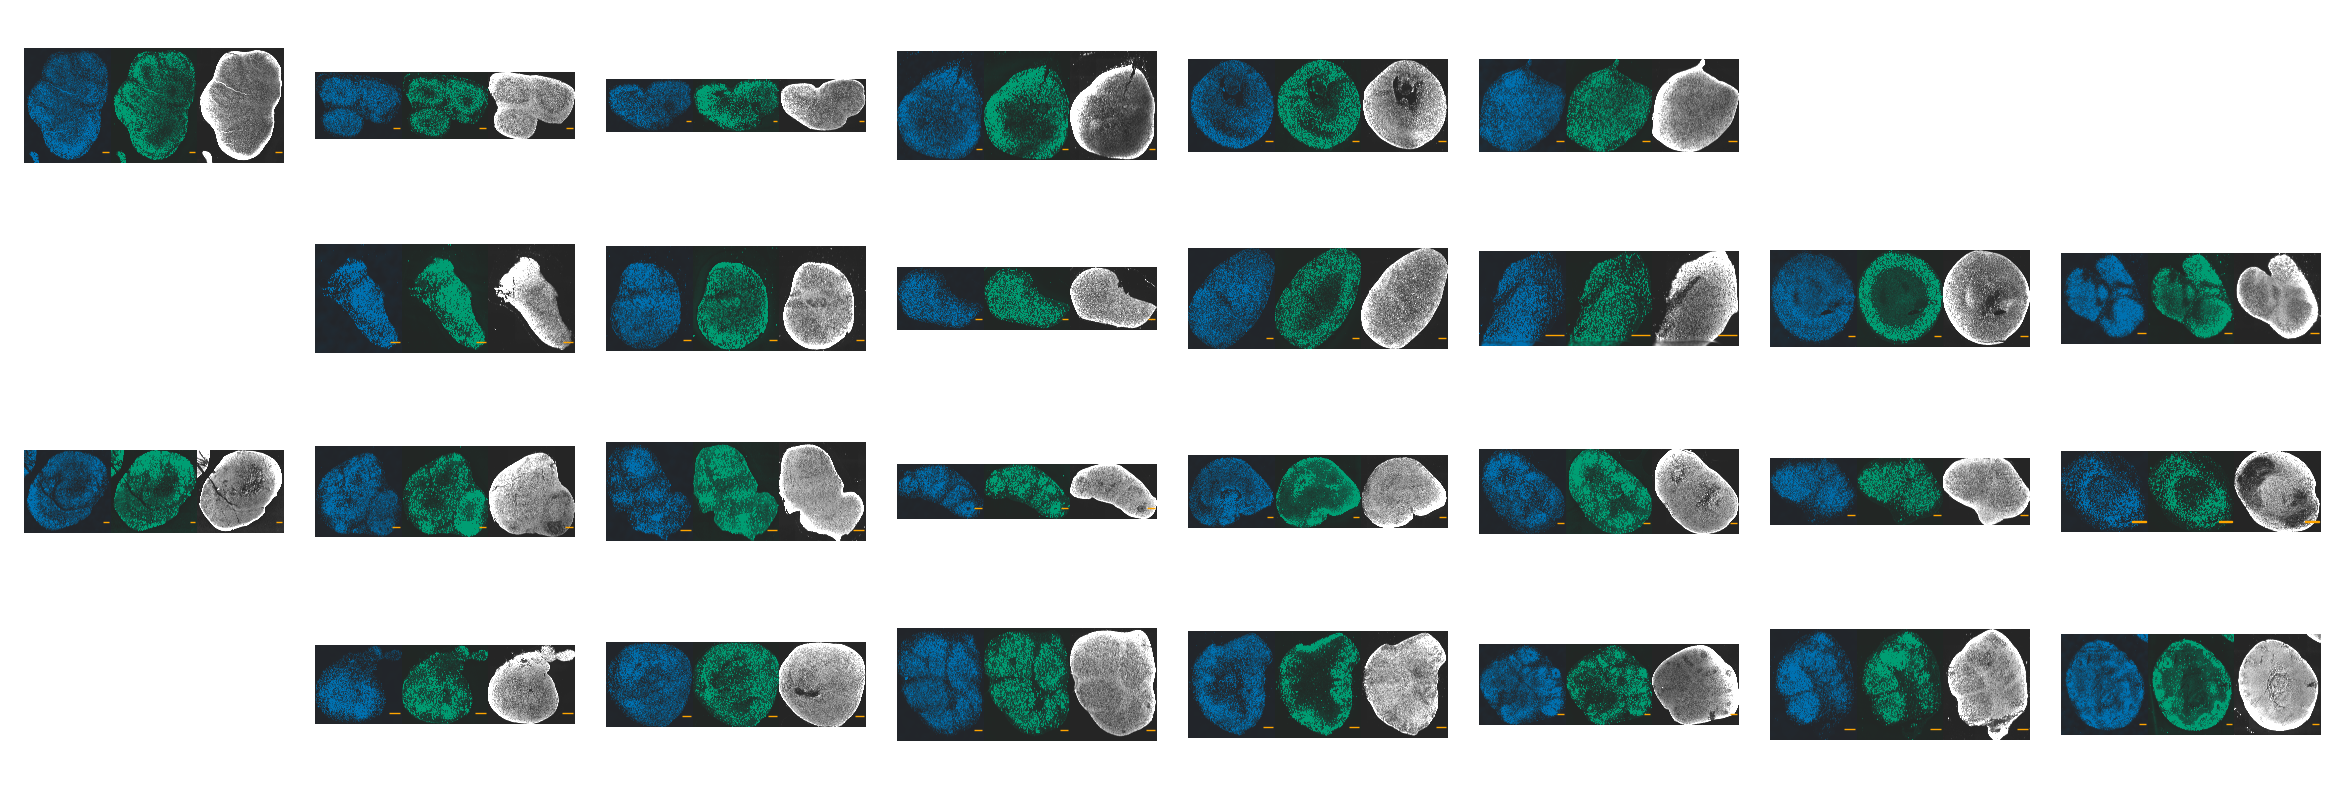

In [ ]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fig, ax = plt.subplots(4, 8, figsize=(30, 10), gridspec_kw={'hspace': 0.01, 'wspace': 0.01})

for a in ax.flatten():
    a.set_facecolor('none')

fig.patch.set_facecolor('none') # sfondo trasparente

ax = ax.flatten().T

for ax, condition in zip(ax, conditions):

    if condition == '':
        ax.axis('off')
        continue
    
    imagename_scanregion = sample_sheet_dict_rev[condition]  # Get the condition for the image
    
    ch0 = tif.imread(plot_dict[imagename_scanregion][0]) 
    ch2 = tif.imread(plot_dict[imagename_scanregion][2])  
    DAPI = tif.imread(plot_dict[imagename_scanregion][3])

    ch0 = normalize(ch0)
    ch2 = normalize(ch2)
    DAPI = normalize(DAPI)

    ax.axis('off')

    # Create 1x3 grid of insets inside this Axes
    
    for i in range(1):
        for j in range(3):
            x0 = 0.05 + j * 0.3
            y0 = 0.05 + i * 0.9
            inset = inset_axes(ax, width="30%", height="90%", loc='lower left',
                              bbox_to_anchor=(x0, y0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
            if j == 0:
                inset.imshow(DAPI, cmap=colors[3], vmin=np.quantile(DAPI, .1), vmax=np.quantile(DAPI, .9))
            
            elif j == 1:
                inset.imshow(ch2, cmap=colors[2], vmin=np.quantile(ch2, .1), vmax=np.quantile(ch2, .9))
            
            else:
                inset.imshow(ch0, cmap=colors[0], vmin=np.quantile(ch0, .1), vmax=np.quantile(ch0, .9))
            
            scalebar = AnchoredSizeBar(
                inset.transData,
                200 / pixel_size,
                '',
                'lower right',
                pad=0.2,
                color='orange',
                frameon=False,
                size_vertical=2,
                fontproperties=fm.FontProperties(size=5)
            )
            
            inset.add_artist(scalebar)
            inset.axis('off')

#plt.savefig('/group/testa/Users/alessia.valenti/NewImageAnalysis/endpoints_plot_representative_images_MIX2.png', dpi=600, bbox_inches='tight')
#plt.savefig('/group/testa/Users/alessia.valenti/NewImageAnalysis/endpoints_plot_representative_images_MIX2.pdf', dpi=600, bbox_inches='tight')
plt.savefig('/group/testa/Users/alessia.valenti/NewImageAnalysis/endpoints_plot_representative_images_MIX1.eps', format='eps', dpi = 1200)

plt.show()